In [17]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')

## Load the relevent packages
library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 3

---
# 3. Determine MLD
This section reads in the CTD downcast files and identifies the 0.03 density change to calculate the MLD. THe MLD is then linearly interpolated onto the ship's track.

In [33]:
## Read in the data files and convert the excel time
ctd.log = read.xlsx('./Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet = 'Data')
ctd.data = read.xlsx('./Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')

str(ctd.data)

'data.frame':	41780 obs. of  34 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo     : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime_GMT: num  42888 42888 42888 42888 42888 ...
 $ Direction   : chr  "down" "down" "down" "down" ...
 $ Pressure    : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth       : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C       : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C       : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1       : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2       : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ OxymicroM   : num  195 196 195 195 195 ...
 $ OxyPerSat   : num  81 81.1 81 80.9 80.8 ...
 $ SurPAR      : num  8632 8632 8632 8632 8632 ...
 $ PAR         : num  1292 1053 887 775 688 ...
 $ Cpar        : num  0.1496

In [96]:
## this section calculates the mld for each cast
mld = data.frame(Lat = 0, Long = 0, mld = 0, Cast = 0)
mld.times = c()

## Choose a delta rho from rho.10
#delta.rho = 0.03
#delta.rho = 0.05
delta.rho = 0.1
#delta.rho = 0.125

ctd.data = ctd.data[ctd.data$Pressure >= 10,] ## Remove shallow data since mld will be defined as > 10m

## Go through each cast and determine the MLD and then save that depth to a table.
for (i in unique(ctd.data$Cast)){
    
    ## Select the relevent density profile
    l = which(ctd.data$Cast == i)
    rho = ctd.data$Sigma_00[l]
    if (all(is.na(rho))) {
        rho = ctd.data$Sigma_11[l]
    }
    
    #if (length(l) > 5) { ## make sure it was a real cast (i.e. more than 10 data points)
        
        l.log = which(ctd.log$Cast == i)[1]  # Which entry is this cast in the ctd log?
        rho.10 = rho[ctd.data$Pressure[l] == 10]  # density at 10 meters depth
        
        ll = which.min(abs(rho - (rho.10 + delta.rho)))# What is the closest density to rho10 + 0.03?
        
        # Save the Data
        mld = rbind(mld, c(ctd.log$Lat[l.log], ctd.log$Long[l.log], ctd.data$Pressure[l[ll]], i) )
        mld.times = c(mld.times, ctd.data$DateTime_GMT[l[ll]])
    #}
}
nrow(mld)
length(unique(ctd.data$Cast))
mld.times = conv_excel_time(mld.times)
mld = mld[-1,]

ctd.times = conv_excel_time(ctd.data$DateTime_GMT)

[1] 91

[1] 90

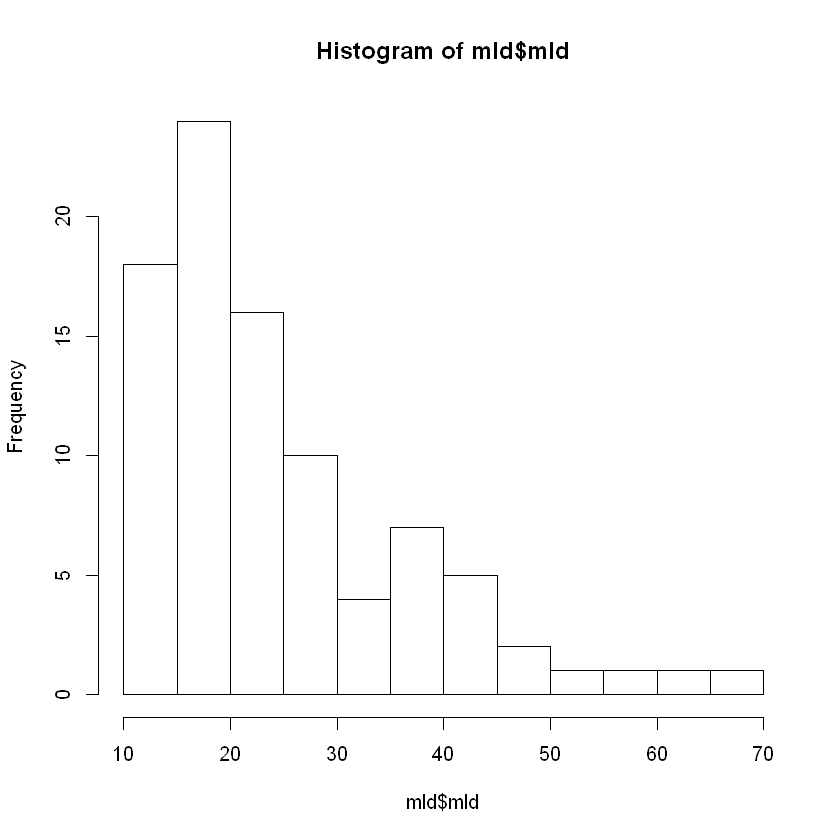

In [83]:
#par(mfrow=c(2,2))
hist(mld$mld, breaks = 20)

In [102]:
#target.time = strptime("2017/06/18 05:15", format="%Y/%m/%d %H:%M", tz='UTC')
target.time = strptime("2017/06/18 1:15", format="%Y/%m/%d %H:%M", tz='UTC')
#target.time = strptime("2017/06/18 05:15", format="%Y/%m/%d %H:%M", tz='UTC')

d.max = 100
cast = ctd.data$Cast[which.min(as.numeric(difftime(ctd.times, target.time, units='hours'))^2)]
name = paste("Cast -", cast)


## Plotting
#pdf(paste0('Output/CTD Profile + MLD-', name, '.pdf'))
par(mfrow=c(2,2))

l = which(ctd.data$Cast == cast)
plot(ctd.data$T190C[l], ctd.data$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Temperature', main=name)
lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

plot(ctd.data$OxymicroM[l], ctd.data$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='uM Oxygen', main=name)
lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

plot(ctd.data$Sigma_11[l], ctd.data$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Density', main=name)
lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

plot(ctd.data$Fluor[l], ctd.data$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Fluorometer', main=name)
lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

#dev.off()

png 
  2

## Save the results

In [16]:
save(mld, file=paste0('./RStates/mld-', delta.rho ,'.rdata'))
save(mld.times, file=paste0('./RStates/mld.times-', delta.rho ,'.rdata'))